# EDA

In [45]:
import pybgpstream
import pandas as pd

## Cloudflare 1.1.1.1 incident on June 27, 2024

https://blog.cloudflare.com/cloudflare-1111-incident-on-june-27-2024/

Some of the difficulty comes from potential routing hijacks of 1.1.1.1. For example, if some fictitious FooBar Networks assigns 1.1.1.1/32 to one of their routers and shares this prefix within their internal network, their customers will have difficulty routing to the 1.1.1.1 DNS service. If they advertise the 1.1.1.1/32 prefix outside their immediate network, the impact can be even greater. The reason 1.1.1.1/32 would be selected instead of the 1.1.1.0/24 BGP-announced by Cloudflare is due to Longest Prefix Matching (LPM). While many prefixes in a route table could match the 1.1.1.1 address, such as 1.1.1.0/24, 1.1.1.0/29, and 1.1.1.1/32, 1.1.1.1/32 is considered the “longest match” by the LPM algorithm because it has the highest number of identical bits and longest subnet mask while matching the 1.1.1.1 address. In simple terms, we would call 1.1.1.1/32 the “most specific” route available to 1.1.1.1.

- **2024-06-27 18:51:00** `AS267613` (Eletronet) begins announcing 1.1.1.1/32 to peers, providers, and customers. 1.1.1.1/32 is announced with the AS267613 origin AS

- **2024-06-27 22:16:00** AS262504 leaks 1.1.1.0/24 again, attracting some traffic to a Cloudflare peering with `AS267613` in São Paulo. Some 1.1.1.1 requests as a result are returned with higher latency, but the hijack of 1.1.1.1/32 and traffic blackholing appears resolved

### Get data

In [46]:
stream = pybgpstream.BGPStream(
    #project="route-views",          # Proyecto
    collectors  =   ["route-views.sg"],     # Collector remoto
    record_type =   "updates",             # "ribs" o "updates"
    from_time   =   "2024-06-27 18:00:00",  # Inicio del rango
    until_time  =   "2024-06-27 22:30:00",     # Fin del rango (aquí 5 minutos)

)

rows = []

# Iterar sobre los registros en tiempo real o históricos
for rec in stream.records():
    for elem in rec:
        fields = elem.fields
        rows.append({
            "time": rec.time,
            "project": rec.project,
            "collector": rec.collector,
            "peer_asn": fields.get("peer-asn"),
            "peer_ip": fields.get("peer-address"),
            "type": elem.type,           # "RIB", "A" (announce), "W" (withdraw)
            "prefix": fields.get("prefix"),
            "next_hop": fields.get("next-hop"),
            "as_path": fields.get("as-path"),
            "origin": fields.get("origin"),
            "local_pref": fields.get("local-pref"),
            "med": fields.get("med"),
            "communities": fields.get("communities"),
        })

# Convertir a DataFrame
df = pd.DataFrame(rows)
print(f'Dataframe with {len(df):,} rows')

Dataframe with 12,951,898 rows


In [3]:
pd.set_option('display.max_rows', None)

In [47]:
df['formatted_time'] = pd.to_datetime(df['time'], unit='s', utc=True)
df.head(5)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.sg,None,None,A,130.137.150.0/24,27.111.228.6,18106 2914 16509,None,None,None,{2914:2000},2024-06-27 18:00:00.004317045+00:00
1,1.719511e+09,routeviews,route-views.sg,None,None,A,2803:a5c0:4000::/36,2001:de8:4::1:8106:1,18106 2914 1299 262589 262186 273001,None,None,None,{2914:3000},2024-06-27 18:00:00.004468918+00:00
2,1.719511e+09,routeviews,route-views.sg,None,None,W,2a10:ccc7:9367::/48,None,None,None,None,None,None,2024-06-27 18:00:00.046030998+00:00
3,1.719511e+09,routeviews,route-views.sg,None,None,A,2a10:ccc7:9367::/48,2001:de8:4::3:8880:1,38880 4826 20473,None,None,None,{},2024-06-27 18:00:00.046030998+00:00
4,1.719511e+09,routeviews,route-views.sg,None,None,A,169.145.140.0/23,27.111.229.111,24516 3491 3356 14114 6979 6979 6979 6979 6979...,None,None,None,"{14114:1101, 14114:199, 3491:2000, 3491:9080, ...",2024-06-27 18:00:00.079073906+00:00


#### Save data

In [48]:
df.to_parquet('/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024.parquet',
              engine='pyarrow',
              compression='zstd')

In [ ]:
del df

### Load data from file

In [51]:
df_parquet = pd.read_parquet('/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024.parquet',
                             engine='pyarrow')

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [53]:
df_parquet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12951898 entries, 0 to 12951897
Data columns (total 14 columns):
 #   Column          Dtype              
---  ------          -----              
 0   time            float64            
 1   project         object             
 2   collector       object             
 3   peer_asn        object             
 4   peer_ip         object             
 5   type            object             
 6   prefix          object             
 7   next_hop        object             
 8   as_path         object             
 9   origin          object             
 10  local_pref      object             
 11  med             object             
 12  communities     object             
 13  formatted_time  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1), object(12)
memory usage: 1.4+ GB


In [54]:
df_parquet.head(10)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.sg,None,None,A,130.137.150.0/24,27.111.228.6,18106 2914 16509,None,None,None,[2914:2000],2024-06-27 18:00:00.004317045+00:00
1,1.719511e+09,routeviews,route-views.sg,None,None,A,2803:a5c0:4000::/36,2001:de8:4::1:8106:1,18106 2914 1299 262589 262186 273001,None,None,None,[2914:3000],2024-06-27 18:00:00.004468918+00:00
2,1.719511e+09,routeviews,route-views.sg,None,None,W,2a10:ccc7:9367::/48,None,None,None,None,None,None,2024-06-27 18:00:00.046030998+00:00
3,1.719511e+09,routeviews,route-views.sg,None,None,A,2a10:ccc7:9367::/48,2001:de8:4::3:8880:1,38880 4826 20473,None,None,None,[],2024-06-27 18:00:00.046030998+00:00
4,1.719511e+09,routeviews,route-views.sg,None,None,A,169.145.140.0/23,27.111.229.111,24516 3491 3356 14114 6979 6979 6979 6979 6979...,None,None,None,"[14114:1101, 14114:199, 3491:2000, 3491:9080, ...",2024-06-27 18:00:00.079073906+00:00
5,1.719511e+09,routeviews,route-views.sg,None,None,A,2606:6e00:8000::/35,2001:de8:4::2:4516:2,24516 7296,None,None,None,"[19996:19996, 24516:1400, 24516:3, 24516:104, ...",2024-06-27 18:00:00.079256058+00:00
6,1.719511e+09,routeviews,route-views.sg,None,None,A,81.192.239.0/24,27.111.229.252,16552 4637 5511 6713 6713 6713 6713 6713 6713 ...,None,None,None,"[4637:32504, 4637:60952, 16552:20702, 4637:320...",2024-06-27 18:00:09.985863924+00:00
7,1.719511e+09,routeviews,route-views.sg,None,None,A,45.172.92.0/22,27.111.229.252,16552 2914 6453 32098 17072 17072 17072 17072 ...,None,None,None,"[2914:420, 2914:3000, 2914:2000, 16552:20702, ...",2024-06-27 18:00:09.985918999+00:00
8,1.719511e+09,routeviews,route-views.sg,None,None,A,123.136.68.0/24,27.111.229.252,16552 23856 139883 23767,None,None,None,"[16552:9150, 24115:24115, 24115:65023, 24115:2...",2024-06-27 18:00:09.985935926+00:00
9,1.719511e+09,routeviews,route-views.sg,None,None,A,192.122.140.0/24,27.111.229.252,16552 23856 139883 23767,None,None,None,"[16552:9150, 24115:24115, 24115:65023, 24115:2...",2024-06-27 18:00:09.985935926+00:00


,type,count
0,A,12075381
1,W,876517


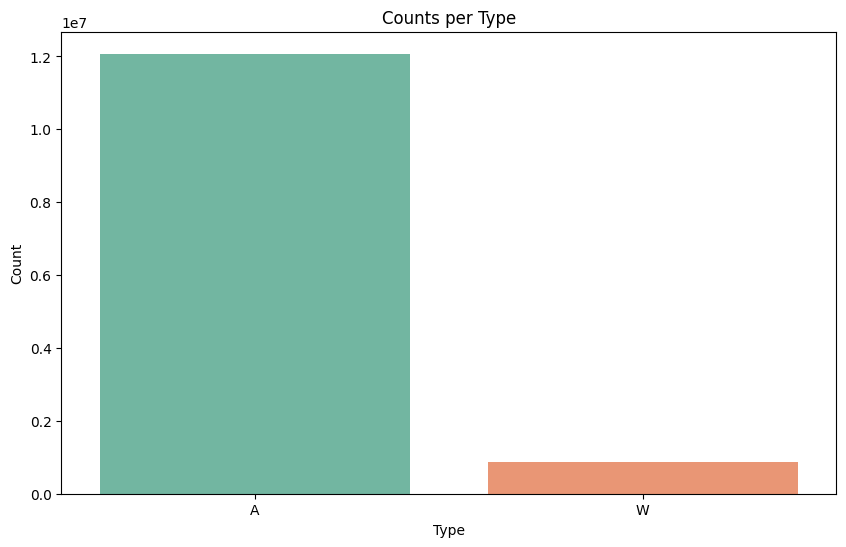

In [56]:
df_types = (
    df_parquet['type']
    .value_counts()
    .reset_index()
)

display(df_types)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_types, x='type', y='count', palette='Set2', hue='type')
plt.title('Counts per Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()